 ## C add attributes 2 and begin feat engineering
 Design matrix is one record per row


In [1]:
# formatting
import jupyter_black

jupyter_black.load(
)

In [2]:
# imports

import pandas as pd
import numpy as np  # for np.nan
import os  # for path

import yfinance as yf

import json

from pandas_datareader.quandl import QuandlReader  # data side

reload_data = True
end_date = "2030-12-31"

In [3]:
with open("data/vars.json", "r") as json_file:
    var_dict = json.load(json_file)

In [4]:
# read in raw data
### INPUT ###

# formatted tradelog
trades_filename = "output/b_completewattr.csv"
df_raw = pd.read_csv(trades_filename)

### Existing Cols with Issues

In [5]:
existing_err_cols = [
    "AAII_SENT_Date",
    "AAII_SENT_Bullish",  ## AAII columns are missing later 2021 and 2022 values
    "AAII_SENT_Neutral",
    "AAII_SENT_Bearish",
    "AAII_SENT_Total",
    "AAII_SENT_Bullish8WeekMovAvg",
    "AAII_SENT_BullBearSpread",
    "AAII_SENT_BullishAverage",
    "AAII_SENT_BullishAverage+StDev",
    "AAII_SENT_BullishAverageStDev",
    "AAII_SENT_S&P500WeeklyHigh",
    "AAII_SENT_S&P500WeeklyLow",
    "AAII_SENT_S&P500WeeklyClose",
]

## pull data from yahoo finance

In [6]:
tickers = ["^VIX", "^GSPC"]
if reload_data:
    df_data = yf.download(
        " ".join(tickers), start="2010-01-01", end=end_date, group_by="Tickers"
    )
    # turn into tabular form
    df_data_formatted = (
        df_data.stack(level=0).reset_index().rename(columns={"level_1": "Ticker"})
    )
    df_data_formatted.to_csv("output/c_mktdata.csv")
else:
    df_data_formatted = pd.read_csv("output/c_mktdata.csv")

df_data_formatted.head()

C:\Users\Stanley\AppData\Local\Temp\ipykernel_19624\3944701004.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_data = yf.download(


[                       0%                       ]

[*********************100%***********************]  2 of 2 completed

Price,Date,Ticker,Close,High,Low,Open,Volume
0,2010-01-04,^GSPC,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
1,2010-01-04,^VIX,20.040001,21.680000,20.030001,21.680000,0
2,2010-01-05,^GSPC,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
3,2010-01-05,^VIX,19.350000,20.129999,19.340000,20.049999,0
4,2010-01-06,^GSPC,1137.140015,1139.189941,1133.949951,1135.709961,4972660000


In [7]:
# pivoted

df_data_pivot = df_data_formatted.pivot(
    index=["Date"],
    columns=["Ticker"],
    values=["Close"],
).reset_index()

# to deal with multiindex columns
df_data_pivot.columns = ["_".join(col).strip() for col in df_data_pivot.columns.values]
df_data_pivot.rename(columns={"Date_": "Date_YahooFinance"}, inplace=True)
df_data_pivot["Date_YahooFinance"] = pd.to_datetime(
    df_data_pivot["Date_YahooFinance"], errors="coerce"
)
df_data_pivot.head()

,Date_YahooFinance,Close_^GSPC,Close_^VIX
0,2010-01-04,1132.989990,20.040001
1,2010-01-05,1136.520020,19.350000
2,2010-01-06,1137.140015,19.160000
3,2010-01-07,1141.689941,19.059999
4,2010-01-08,1144.979980,18.129999


In [8]:
df_data_pivot["Close_^GSPC_200MA"] = df_data_pivot["Close_^GSPC"].rolling(200).mean()
df_data_pivot["SP500from200MA"] = (
    df_data_pivot["Close_^GSPC"] - df_data_pivot["Close_^GSPC_200MA"]
) / df_data_pivot["Close_^GSPC_200MA"]
df_data_pivot.tail()

,Date_YahooFinance,Close_^GSPC,Close_^VIX,Close_^GSPC_200MA,SP500from200MA
3973,2025-10-20,6735.129883,18.230000,6070.444741,0.109495
3974,2025-10-21,6735.350098,17.870001,6074.778743,0.108740
3975,2025-10-22,6699.399902,18.600000,6078.563391,0.102135
3976,2025-10-23,6738.439941,17.299999,6082.378691,0.107863
3977,2025-10-24,6791.689941,16.370001,6086.791992,0.115808


In [9]:
# merge

df_source = df_raw.copy(deep=True)

df_source["Open_Date"] = pd.to_datetime(df_source["Open_Date"], errors="coerce")


# need to sort
df_source = df_source.sort_values(["Open_Date"])
df_data_pivot = df_data_pivot.sort_values(["Date_YahooFinance"])

df_result = pd.merge_asof(
    df_source, df_data_pivot, left_on=["Open_Date"], right_on=["Date_YahooFinance"]
)

### Add Open Year

In [10]:
df_result["Open_Year"] = df_result["Open_Date"].dt.year

### Test data

In [11]:
df_result.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Open_Date', 'Close_Date', 'Symbol',
       'Quantity', 'Pnl', 'OpenAct', 'CloseAct', 'Open_Price', 'Close_Price',
       'Comm_Tot', 'DATE', 'ACTION', 'QTYCHG', 'PRICE', 'TIME', 'UNNAMED: 6',
       'COMMISSION', 'UNNAMED: 8', 'CASH CHG (PNL)', 'COMMENTS', 'PCTRETURN',
       'DETAILS', 'STARTDATE', 'COMPANY NAME (IN ALPHABETICAL ORDER)',
       'TICKER', 'STOP', '% TO STOP', 'CURRENT PRICE', '% TO TARGET',
       'AT PRICE', 'TARGET', 'EPS1', 'EPS2', 'FYEND', 'DAYSTOFYEND',
       'FYEPSNXT', 'GROWTH*0.5TO0.75', 'ROIC (BW ROA ROE)', 'TGT FWD P/E',
       'YEARS TO NORMALIZATION', 'LASTUPDATED', 'CATEGORY', 'COMMENTS.1',
       'FILENAME', 'DayOfWeek0Mon', 'Date_YahooFinance', 'Close_^GSPC',
       'Close_^VIX', 'Close_^GSPC_200MA', 'SP500from200MA', 'Open_Year'],
      dtype='object')

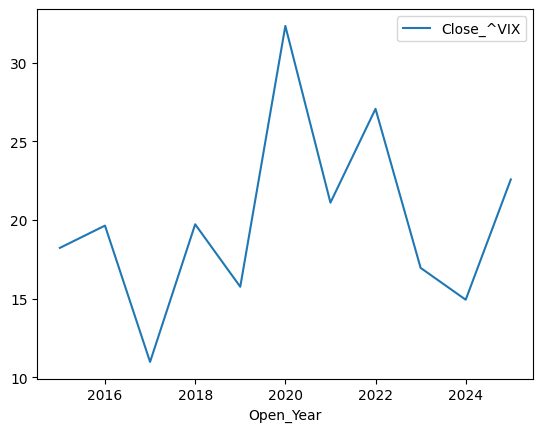

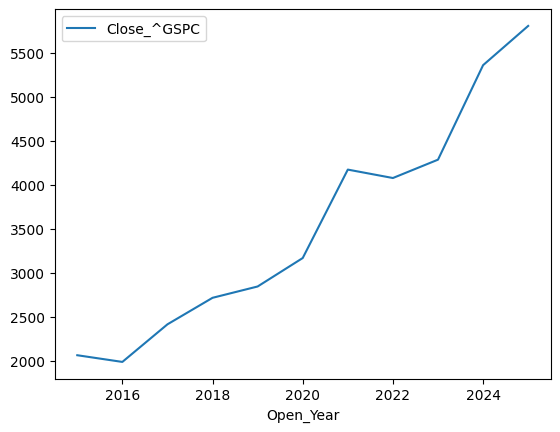

In [12]:
for symbol in tickers:
    temp_df = pd.pivot_table(
        df_result,
        index=["Open_Year"],
        values="Close_" + symbol,
        aggfunc="mean",
        dropna=False,
    )
    temp_df.plot()

    assert min(temp_df["Close_" + symbol]) > 0, "values should all be above zero"

## pull data from Quandl  / Nasdaq Data Link
1. log in is from [Nasdaq data link](https://docs.data.nasdaq.com/docs/python-installation)

In [13]:
externalvar_dict = {
    #     "AAII/AAII_SENTIMENT": "AAII_SENT",  ## aaii sentiment looks like it ends 4/2021
    # "UMICH/SOC1": "CONS_SENT",  # consumer sentiment, not used ofr now 
    #     "FED/RIMLPAAAR_N_B": "FED_AAACORP",  ## daily Fed AAA rates #TODO ned to fix different timeframes
}

In [14]:
# for later
# import nasdaqdatalink

# NASDAQ_DATA_LINK_API_KEY = var_dict["NASDAQ_DATA_LINK_API_KEY"]
# data = nasdaqdatalink.get("AAII/AAII_SENTIMENT", start_date="2015-01-01", end_date="2030-12-31")

In [15]:
if reload_data:

    #     df_varlist = []

    for variable, value in externalvar_dict.items():

        quandl_key = var_dict["QUANDL_API"]

        QR = QuandlReader(variable, api_key=quandl_key, start="1/1/2015", end=end_date)

        QR_df = QR.read().reset_index()

        QR_df.columns = [
            value + "_" + str(col)  # if col.upper() != "DATE" else col
            for col in QR_df.columns
        ]

        #         df_varlist.append(QR_df)

        # merge Quandl
        QR_df_sorted = QR_df.sort_values([f"{value}_Date"])
        QR_df_sorted["Date"] = pd.to_datetime(QR_df[f"{value}_Date"], errors="coerce")

        # add iteratively
        df_result = pd.merge_asof(
            df_result,
            QR_df_sorted,
            left_on=["Open_Date"],
            right_on=[f"{value}_Date"],
            direction="backward",  # can't see forward
        )

        #     QR_df = pd.concat(
        #         [df.set_index("Date") for df in df_varlist], axis=1, join="outer"
        #     ).reset_index()
        QR_df.to_csv(f"output/c_quandl_{value}.csv")
else:
    for variable, value in externalvar_dict.items():

        QR_df = pd.read_csv(f"output/c_quandl_{value}.csv")

        # merge Quandl
        QR_df_sorted = QR_df.sort_values(["Date"])
        QR_df_sorted["Date"] = pd.to_datetime(QR_df[f"{value}_Date"], errors="coerce")

        df_result = pd.merge_asof(
            df_result,
            QR_df_sorted,
            left_on=["Open_Date"],
            right_on=[f"{value}_Date"],
            direction="backward",  # can't see forward
        )

In [16]:
df_result.head()

,Unnamed: 0.1,Unnamed: 0,Open_Date,Close_Date,Symbol,Quantity,Pnl,OpenAct,CloseAct,Open_Price,...,CATEGORY,COMMENTS.1,FILENAME,DayOfWeek0Mon,Date_YahooFinance,Close_^GSPC,Close_^VIX,Close_^GSPC_200MA,SP500from200MA,Open_Year
0,0,0,2015-06-30,2016-01-07 11:12:44,AER,600.0,-4851.23,B,S,46.972120,...,NaN,NaN,PCM-Tracking - LogHist.csv,1.0,2015-06-30,2063.110107,18.23,2053.895403,0.004486,2015
1,63,19,2015-06-30,2016-01-07 14:17:55,FNMAS,1500.0,-2890.12,B,S,5.071132,...,Value,NaN,PCM-Tracking - LogHist.csv,3.0,2015-06-30,2063.110107,18.23,2053.895403,0.004486,2015
2,62,692,2015-06-30,2016-10-24 11:08:39,ENH,50.0,1245.34,B,S,66.956667,...,NaN,NaN,PCM-Tracking - LogHist.csv,4.0,2015-06-30,2063.110107,18.23,2053.895403,0.004486,2015
3,61,64,2015-06-30,2016-01-20 15:22:41,VALE,8000.0,6677.80,S,B,3.184507,...,NaN,NaN,PCM-Tracking - LogHist.csv,1.0,2015-06-30,2063.110107,18.23,2053.895403,0.004486,2015
4,60,761,2015-06-30,2017-03-10 10:03:51,MKL,10.0,4008.29,B,S,579.659697,...,Value,NaN,PCM-Tracking - LogHist.csv,3.0,2015-06-30,2063.110107,18.23,2053.895403,0.004486,2015


In [17]:
cols_with_errors = []

for variable, value in externalvar_dict.items():
    for c in df_result.columns:
        if value in c:
            temp_df = pd.pivot_table(
                df_result, index=["Open_Year"], values=c, aggfunc="mean", dropna=False
            )
            temp_df.plot()

            try:
                assert sum(temp_df[c].isna()) == 0, "values should all be filled"
            except:
                cols_with_errors.append(c)

In [18]:
cols_with_errors

[]

In [19]:
temp_df

,Close_^GSPC
Open_Year,
2015,2063.110107
2016,1987.011646
2017,2414.437274
2018,2715.997326
2019,2844.703275
2020,3168.279058
2021,4173.741877
2022,4077.974448
2023,4286.556631


In [20]:
# check diff
assert len(set(cols_with_errors).difference(set(existing_err_cols))) == 0, "new errors"

## Pull AAII Sentiment Data
Source: https://www.aaii.com/sentimentsurvey/sent_results

In [21]:
df_aaii = pd.read_excel(f"data\sentiment.xls", header=[1, 2, 3])

In [22]:
df_aaii.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
              Reported           Reported           Reported   
                  Date            Bullish            Neutral   
0                  NaN                NaN                NaN   
1  1987-06-26 00:00:00                NaN                NaN   
2  1987-07-17 00:00:00                NaN                NaN   
3  1987-07-24 00:00:00               0.36               0.50   
4  1987-07-31 00:00:00               0.26               0.48   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Bullish                                \
            Reported           Reported  8-week Bull-Bear   Bullish   Average   
             Bearish              Total Mov Avg    Spread   Average +St. Dev.   
0                NaN                NaN     NaN       NaN       NaN       NaN   
1                NaN                NaN     NaN       NaN  0.376075  0.476796   
2                NaN                NaN     NaN       NaN  0.376075  0.476796   
3               0.14                1.0     NaN      0.22  0.376075  0.476796   
4               0.26                1.0     NaN      0.00  0.376075  0.476796   

             S&P 500                          
              Weekly                          
  - St. Dev.    High     Low   Close Close.1  
0        NaN     NaN     NaN     NaN     NaN  
1   0.275354     NaN     NaN     NaN     NaN  
2   0.275354  314.59  307.63  314.59     NaN  
3   0.275354  311.39  307.81  309.27     NaN  
4   0.275354  318.66  310.65  318.66     NaN

In [23]:
df_aaii.tail()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
               Reported           Reported           Reported   
                   Date            Bullish            Neutral   
2193          Count '20               53.0               53.0   
2194          Count '21               51.0               51.0   
2195          Count '22               52.0               52.0   
2196          Count '23               52.0               52.0   
2197          Count '24               51.0               51.0   

     Unnamed: 3_level_0 Unnamed: 4_level_0 Bullish                    \
               Reported           Reported  8-week Bull-Bear Bullish   
                Bearish              Total Mov Avg    Spread Average   
2193               53.0                NaN    53.0      53.0     NaN   
2194               51.0                NaN    51.0      51.0     NaN   
2195               52.0                NaN    52.0      52.0     NaN   
2196               52.0                NaN    52.0      52.0     NaN   
2197               51.0                NaN    51.0      51.0     NaN   

                          S&P 500                      
       Average             Weekly                      
     +St. Dev. - St. Dev.    High   Low Close Close.1  
2193       NaN        NaN    53.0  53.0  53.0     NaN  
2194       NaN        NaN    51.0  51.0  51.0     NaN  
2195       NaN        NaN    52.0  52.0  52.0     NaN  
2196       NaN        NaN    52.0  52.0  52.0     NaN  
2197       NaN        NaN    51.0  51.0  51.0       x

In [24]:
# squeeze multilevel columns to one
col_list = list(df_aaii.columns.map("_".join))
col_list = [s.replace("Unnamed: ", "") for s in col_list]
col_list

['0_level_0_Reported_Date',
 '1_level_0_Reported_Bullish',
 '2_level_0_Reported_Neutral',
 '3_level_0_Reported_Bearish',
 '4_level_0_Reported_Total',
 'Bullish_8-week_Mov Avg',
 'Bullish_Bull-Bear_Spread',
 'Bullish_Bullish_Average',
 'Bullish_Average_+St. Dev.',
 'Bullish_Average_- St. Dev.',
 'S&P 500_Weekly_High',
 'S&P 500_Weekly_Low',
 'S&P 500_Weekly_Close',
 'S&P 500_Weekly_Close.1']

In [25]:
df_aaii.columns = col_list
df_aaii.columns

Index(['0_level_0_Reported_Date', '1_level_0_Reported_Bullish',
       '2_level_0_Reported_Neutral', '3_level_0_Reported_Bearish',
       '4_level_0_Reported_Total', 'Bullish_8-week_Mov Avg',
       'Bullish_Bull-Bear_Spread', 'Bullish_Bullish_Average',
       'Bullish_Average_+St. Dev.', 'Bullish_Average_- St. Dev.',
       'S&P 500_Weekly_High', 'S&P 500_Weekly_Low', 'S&P 500_Weekly_Close',
       'S&P 500_Weekly_Close.1'],
      dtype='object')

In [26]:
# save only those with dates
saved_idx = ~pd.to_datetime(df_aaii["0_level_0_Reported_Date"], errors="coerce").isna()

In [27]:
# final usable
df_aaii = df_aaii.loc[saved_idx]
df_aaii["Date"] = pd.to_datetime(df_aaii["0_level_0_Reported_Date"])
df_aaii.head()

,0_level_0_Reported_Date,1_level_0_Reported_Bullish,2_level_0_Reported_Neutral,3_level_0_Reported_Bearish,4_level_0_Reported_Total,Bullish_8-week_Mov Avg,Bullish_Bull-Bear_Spread,Bullish_Bullish_Average,Bullish_Average_+St. Dev.,Bullish_Average_- St. Dev.,S&P 500_Weekly_High,S&P 500_Weekly_Low,S&P 500_Weekly_Close,S&P 500_Weekly_Close.1,Date
1,1987-06-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.376075,0.476796,0.275354,NaN,NaN,NaN,NaN,1987-06-26
2,1987-07-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.376075,0.476796,0.275354,314.59,307.63,314.59,NaN,1987-07-17
3,1987-07-24 00:00:00,0.36,0.50,0.14,1.0,NaN,0.22,0.376075,0.476796,0.275354,311.39,307.81,309.27,NaN,1987-07-24
4,1987-07-31 00:00:00,0.26,0.48,0.26,1.0,NaN,0.00,0.376075,0.476796,0.275354,318.66,310.65,318.66,NaN,1987-07-31
5,1987-08-07 00:00:00,0.56,0.15,0.29,1.0,NaN,0.27,0.376075,0.476796,0.275354,323.00,316.23,323.00,NaN,1987-08-07


In [28]:
df_aaii_sorted = df_aaii.sort_values(["0_level_0_Reported_Date"])
df_aaii_sorted.columns = ["AAII_" + c for c in df_aaii_sorted.columns]
df_result = pd.merge_asof(
    df_result,
    df_aaii_sorted,
    left_on=["Open_Date"],
    right_on=[f"AAII_Date"],
    direction="backward",
)
df_result.head()

,Unnamed: 0.1,Unnamed: 0,Open_Date,Close_Date,Symbol,Quantity,Pnl,OpenAct,CloseAct,Open_Price,...,AAII_Bullish_8-week_Mov Avg,AAII_Bullish_Bull-Bear_Spread,AAII_Bullish_Bullish_Average,AAII_Bullish_Average_+St. Dev.,AAII_Bullish_Average_- St. Dev.,AAII_S&P 500_Weekly_High,AAII_S&P 500_Weekly_Low,AAII_S&P 500_Weekly_Close,AAII_S&P 500_Weekly_Close.1,AAII_Date
0,0,0,2015-06-30,2016-01-07 11:12:44,AER,600.0,-4851.23,B,S,46.972120,...,0.267945,0.138889,0.376075,0.476796,0.275354,2129.87,2082.1,2108.58,NaN,2015-06-25
1,63,19,2015-06-30,2016-01-07 14:17:55,FNMAS,1500.0,-2890.12,B,S,5.071132,...,0.267945,0.138889,0.376075,0.476796,0.275354,2129.87,2082.1,2108.58,NaN,2015-06-25
2,62,692,2015-06-30,2016-10-24 11:08:39,ENH,50.0,1245.34,B,S,66.956667,...,0.267945,0.138889,0.376075,0.476796,0.275354,2129.87,2082.1,2108.58,NaN,2015-06-25
3,61,64,2015-06-30,2016-01-20 15:22:41,VALE,8000.0,6677.80,S,B,3.184507,...,0.267945,0.138889,0.376075,0.476796,0.275354,2129.87,2082.1,2108.58,NaN,2015-06-25
4,60,761,2015-06-30,2017-03-10 10:03:51,MKL,10.0,4008.29,B,S,579.659697,...,0.267945,0.138889,0.376075,0.476796,0.275354,2129.87,2082.1,2108.58,NaN,2015-06-25


## Final Checks

In [29]:
df_result.loc[0, df_result.columns.duplicated()]

Series([], Name: 0, dtype: object)

In [30]:
assert len(df_result.loc[0, df_result.columns.duplicated()]) == 0, "duplicates"

## Save Output

In [31]:
df_result.to_csv("output/c_resulttradewattr.csv")